# **Assignment 2: Classifying Images of Colon Cancer**

# Introduction

The goal of this machine learning tasks is to classify histopathelogy images of colon cells. For this we will be using **Neural Networks** along with **Deep Learning**.

# Dataset

The dataset used in this project is a modified version of the `CRCHistoPhenotypes` dataset. The dataset consists of **27x27 RGB** images of colon cells from 99 different patients. The dataset has been split into two, `data_labels_mainData.csv` and `data_labels_extraData.csv`, where `data_labels_mainData.csv` consists of labels **isCancerous** and **cell-type**. This dataset only consists of data for the first **60 patients**. While `data_labels_extraData.csv` contains the remaining **39 patients**, but the medical experts have only provided labels for **isCancerous**.

## Task 2 Model: Classifying Cell Type

In this task we will only be devoloping a model for **Classifying Cell Type** and `data_labels_mainData.csv` will be used since it conatins the labels for **cell-type**.

# Loading Dataset and Exploratory Data Analysis (EDA)

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [3]:
print("Number of instances: ", data.shape[0])
print("Number of columns: ", data.shape[1])

Number of instances:  9896
Number of columns:  6


Since the data has been loaded succesfully, let's check whether there are missing values.

In [4]:
data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

We can see that there are no missing values, hence we can move onto **EDA**.

## Distribution of Data

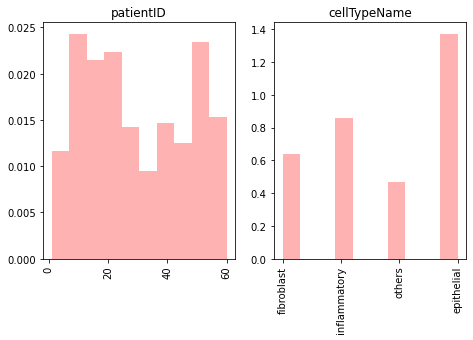

In [5]:
dist_columns = ["patientID", "cellTypeName"]
plt.figure(figsize=(20,20))
for i, col in enumerate(dist_columns):
    plt.subplot(4,5,i+1)
    plt.hist(data[col], alpha=0.3, color='r', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

**Observation:**
- `patientID` is not evenly distributed, need to take into consideration when splitting data.
- `cellType` not evenly distributed, need to take into consideration when training the model.

## Relationship between features

Taking a look at the relationship between `cellTypeName` and `patientID`.

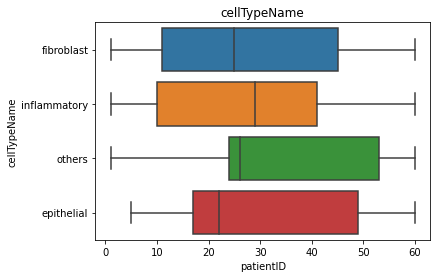

In [6]:
import seaborn as sns
sns.boxplot(data=data, x='patientID', y='cellTypeName')
plt.title(col)
plt.show()

**Observation:**
- `patientID` around 1 to 5 does not seem to have the cell type **epithelial**.

Relationship between `cellTypeName` and `isCancerous`.

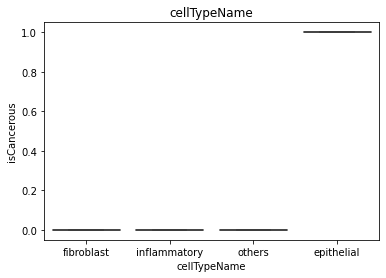

In [7]:
sns.boxplot(data=data, x='cellTypeName', y='isCancerous')
plt.title(col)
plt.show()

**Observation:**
- **epithelial** cell types are all cancerous.

# Splitting Data

In order to create unseen test data, we can split train, validation and test sets by the patient ID.

In [8]:
train_data = data.loc[(data['patientID'] > 20) & (data['patientID'] <= 60)]
val_data = data.loc[(data['patientID'] > 10) & (data['patientID'] <= 20)]
test_data = data.loc[(data['patientID'] > 0) & (data['patientID'] <= 10)]

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 6057, Val Data: 1922, Test Data: 1917


In [9]:
train_data = train_data.sample(frac = 1) # Shuffling training set
val_data = val_data.sample(frac = 1) # Shuffling validation set
test_data = test_data.sample(frac = 1) # Shuffling test set

In [10]:
train_data.head(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
6459,8231,40,8231.png,epithelial,2,1
6425,8197,40,8197.png,epithelial,2,1
5005,22432,27,22432.png,others,3,0
6758,10143,41,10143.png,epithelial,2,1
4870,18448,26,18448.png,others,3,0


## Data Visualisation

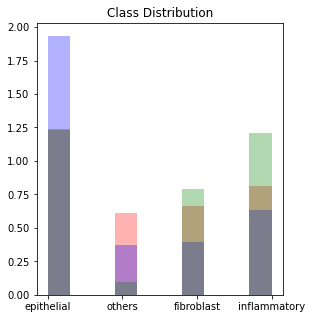

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
_, bins, _ = plt.hist(train_data['cellTypeName'], alpha=0.3, color='r', density=True)
plt.hist(val_data['cellTypeName'], alpha=0.3, color='b', density=True)
plt.hist(test_data['cellTypeName'], alpha=0.3, color='g', density=True)
plt.title("Class Distribution")
plt.show()

From the above histogram it is clear that not all the classes are distributed equally.

In [12]:
train_data['cellTypeName'].value_counts()

epithelial      2255
inflammatory    1481
fibroblast      1205
others          1116
Name: cellTypeName, dtype: int64

In [13]:
val_data['cellTypeName'].value_counts()

epithelial      1115
inflammatory     366
fibroblast       228
others           213
Name: cellTypeName, dtype: int64

In [14]:
test_data['cellTypeName'].value_counts()

epithelial      709
inflammatory    696
fibroblast      455
others           57
Name: cellTypeName, dtype: int64

# Data Preprocessing

## Loading in the images

In this section we will load all the corresponding images for each data set and convert them to numpy arrays.

In [15]:
from PIL import Image
from numpy import asarray

# Path to image directory
path = 'patch_images/'

#Training set
train_x = np.empty((0,27,27,3), int)
for index, row in train_data.iterrows():
    img = Image.open(path + row['ImageName']) # Read in the image file
    img_array = asarray(img)                  # Convert image to numpy array
    img_array = img_array.reshape(1,27,27,3)
    train_x = np.append(train_x, np.array(img_array), axis=0)

In [16]:
# Validation set
val_x = np.empty((0,27,27,3), int)
for index, row in val_data.iterrows():
    img = Image.open(path + row['ImageName']) # Read in the image file
    img_array = asarray(img)                  # Convert image to numpy array
    img_array = img_array.reshape(1,27,27,3)
    val_x = np.append(val_x, np.array(img_array), axis=0)

In [17]:
# Test set
test_x = np.empty((0,27,27,3), int)
for index, row in test_data.iterrows():
    img = Image.open(path + row['ImageName']) # Read in the image file
    img_array = asarray(img)                  # Convert image to numpy array
    img_array = img_array.reshape(1,27,27,3)
    test_x = np.append(test_x, np.array(img_array), axis=0)

Convert labels of each data set into numpy arrays.

In [18]:
# Train set
train_y = train_data['cellType'].to_numpy().reshape(len(train_data['cellType']),1)

# Validation Set
val_y = val_data['cellType'].to_numpy().reshape(len(val_data['cellType']),1)

# Test Set
test_y = test_data['cellType'].to_numpy().reshape(len(test_data['cellType']),1)

Check to see if datasets have been reshaped correctly.

In [19]:
print("train_x.shape :", train_x.shape)
print("train_y.shape :", train_y.shape)
print("val_x.shape :", val_x.shape)
print("val_y.shape :", val_y.shape)
print("test_x.shape :", test_x.shape)
print("test_y.shape :", test_y.shape)

train_x.shape : (6057, 27, 27, 3)
train_y.shape : (6057, 1)
val_x.shape : (1922, 27, 27, 3)
val_y.shape : (1922, 1)
test_x.shape : (1917, 27, 27, 3)
test_y.shape : (1917, 1)


## Data Visualising 

Now the data has been preprocessed, let's take a look at the data in each of the data set with the cell image and label.

### Train Set

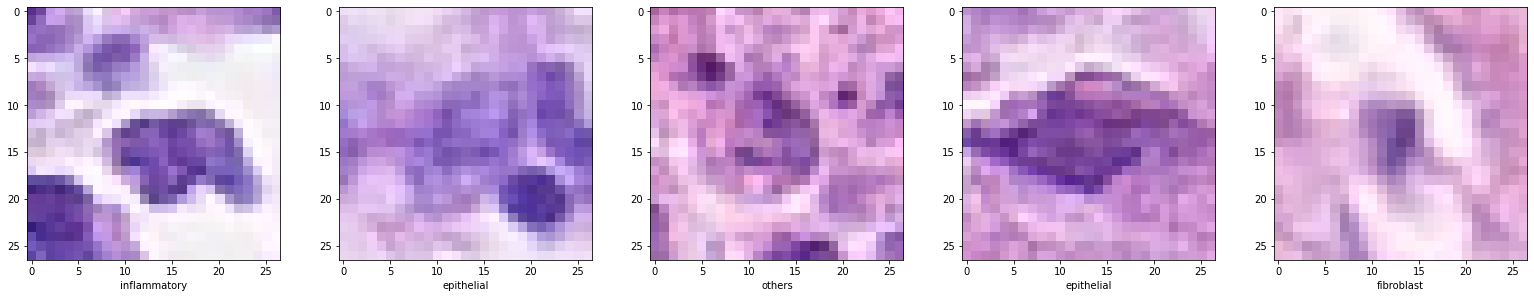

In [19]:
cell_type = ['fibroblast', 'inflammatory', 'epithelial', 'others']
plt.figure(figsize=(27,27))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(train_x[i])
    plt.xlabel(cell_type[train_y[i][0]])

### Validation Set

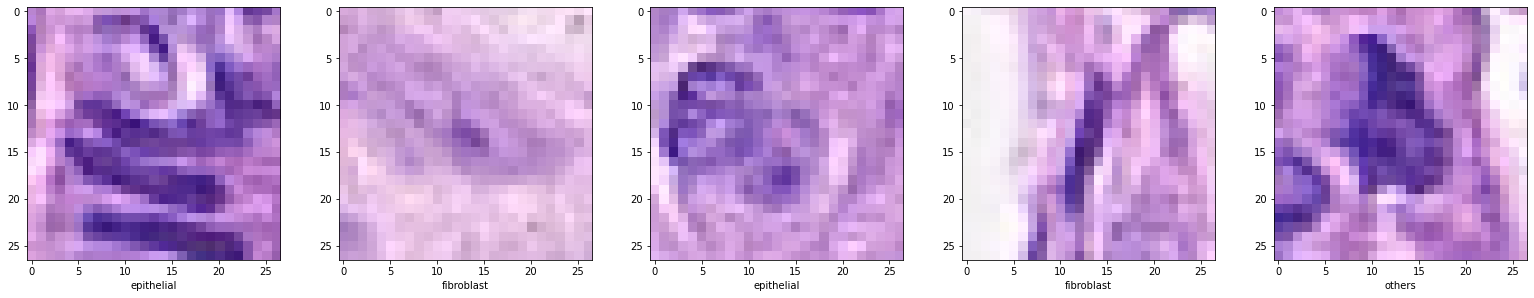

In [20]:
plt.figure(figsize=(27,27))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(val_x[i])
    plt.xlabel(cell_type[val_y[i][0]])

### Test Set

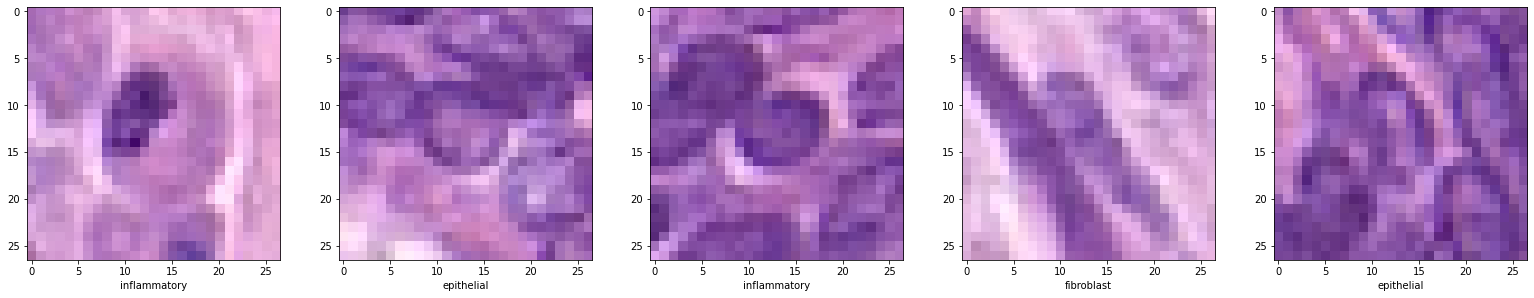

In [21]:
plt.figure(figsize=(27,27))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(test_x[i])
    plt.xlabel(cell_type[test_y[i][0]])

**Observation:**
- The same cell type seems to have variations of shape, colour and orientation.
- The colour of same cell type can vary.
- Not every cell is in the center of the image.
- Some white pixels are present, meaning the brightness can vary.

## Normalizing Images

Since the images contain pixel values between `0 and 255`, which is not ideal for machine learning. We need to normalize these values between `0 and 1`.

In [22]:
# Convert from int to float
train_x = train_x.astype('float32')
val_x = val_x.astype('float32')
test_x = test_x.astype('float32')

train_x /= 255
val_x /= 255
test_x /= 255

# Model development

## Building Base Neural Network Model

In this section we will be using **Keras** to build a simple Neural Network.

### Structure

In [22]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

- Our `Input_Dim` is 27 by 27, since the size of the images are 27x27 pixels. The 3 represent that we are using the RGB colour sheme. 
- We will be using two `Hidden_Layers` with sizes 512 and 256 respectively. Which are randomly chosen values between the output and the input size.
- `Output_Classes` equals to 4, since we have 4 different cell types(classes).

We will be using the `Sequential` API to build our model.

In [23]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

- First layer `Flatten` will convert our input into a one-dimentional array. Here we will specify our input dimensions.
- The first `Dense` layers acts as our Hidden Layer, with a size of 256. 
- Finally the last `Dense` layer is our output layer, which contains a score that determines which class the image belongs to. Here we are using the activation funtion `softmax` as it can convert a vector of values into a probability distribution. Meaning the class with the highest probability is most likely class that the image belongs to.

### Model Summary and Structure Visualised

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [26]:
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Compile Model

In [28]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

- **Optimizer:** We will be using the `adam` optimizer since it is more efficient, and is an improved version of `SGD`.
- **Loss function:** We will be using `sparse_categorical_crossentropy` since our **y** values are integers and also because we have more than 2 classes.
- **Metrics:** We will be using `accuracy` to calculates how often predictions equal labels.

### Training Model

Since our model has been compilled, we can now train the model. We can use our validation set, to evaluate the performance of the model.

In [29]:
base_model = model.fit(train_x, 
                       train_y, 
                       batch_size=32, 
                       epochs=150, 
                       validation_data=(val_x, val_y),
                       verbose=0)

### Visualise Model Accuracy

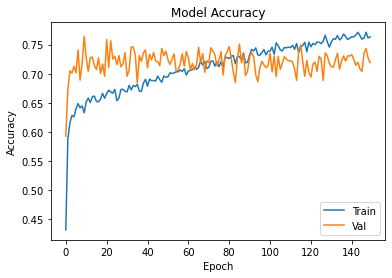

In [30]:
plt.plot(base_model.history['accuracy'])
plt.plot(base_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

### Visualise Model Loss

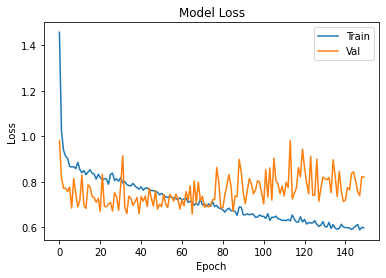

In [31]:
plt.plot(base_model.history['loss'])
plt.plot(base_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [32]:
model.evaluate(train_x, train_y)

190/190 [==============================] - 0s 2ms/step - loss: 0.5580 - accuracy: 0.7750


[0.5579754114151001, 0.7749711275100708]

In [33]:
model.evaluate(val_x, val_y)

61/61 [==============================] - 0s 1ms/step - loss: 0.8199 - accuracy: 0.7190


[0.8199470043182373, 0.7190426588058472]

In [34]:
model.evaluate(test_x, test_y)

60/60 [==============================] - 0s 2ms/step - loss: 0.8769 - accuracy: 0.6656


[0.8768876194953918, 0.6656233668327332]

**Observation:**
- Model is able to have an accuracy of over 70% on the training dataset, but the model produced a lower accuracy for validation dataset.
- From the graphs and results above there seem to be some overfitting. 
- Validation accuracy and loss seem to fluctuate, this may be due to the lack of data.
- Our model seem do to fairly well on unseen data, we can see that the accuracy of test data is somewhat close to the accuracy of training data.

### Improving Base NN Model

Our base model performed fairly well on unseen data, however we can still improve the performance by using a `kerastuner`. <br>
Let's define our base model and choose what values we can change.

In [35]:
!pip install -q -U keras-tuner # Installing packages

In [36]:
import kerastuner as kt

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=INPUT_DIM))
  
  
  # Number of hidden layers to add between 1 to 5
  for i in range(hp.Int('Dense Layers', min_value=1, max_value=5)):
      # Tune the number of units in the first Dense layer
      # Choose an optimal value between 32-1024  
      model.add(keras.layers.Dense(units=hp.Int(f"layer_{i}", min_value=32, max_value=1024, step=32), activation='relu'))
        
  keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

Let's instantiate the tuner to perform the hypertuning.

In [37]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=25,
                     factor=3,
                     directory='NN_Models')

INFO:tensorflow:Reloading Oracle from existing project NN_Models/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from NN_Models/untitled_project/tuner0.json


Let's also include early stopping which can help with overfitting.

In [38]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Searching for best model.

In [39]:
tuner.search(train_x, train_y, epochs=150, validation_data=(val_x, val_y), batch_size=32, callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


Getting the best **model**.

In [40]:
best_NN_model = tuner.get_best_models()[0]
best_NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 480)               1050240   
_________________________________________________________________
dense_1 (Dense)              (None, 192)               92352     
_________________________________________________________________
dense_2 (Dense)              (None, 512)               98816     
Total params: 1,241,408
Trainable params: 1,241,408
Non-trainable params: 0
_________________________________________________________________


Getting the optimal **learning rate**.

In [41]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print("Optimal Learning Rate: ", best_hps.get('learning_rate'))

Optimal Learning Rate:  0.0001


### Re-Training the best model found 

In [42]:
model_best = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(480, activation='relu'),
    keras.layers.Dense(192, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [43]:
model_best.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [44]:
history_best = model_best.fit(train_x, 
                       train_y, 
                       batch_size=32, 
                       epochs=150, 
                       validation_data=(val_x, val_y),
                       verbose=0)

### Visualising performance of improved model

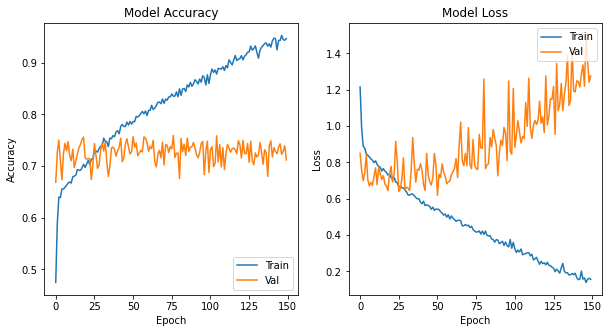

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_best.history['accuracy'])
plt.plot(history_best.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

**Observation:**
- Model achieved a higher accuracy on the training data, however overfitting has increased.

### Applying regularization on the best model found.

Since the model is overfitting we will try to use regularization to deal with this issue.

In [46]:
reg_lambda = 0.01
model_best_REG = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(480, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),   
    keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [47]:
model_best_REG.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [48]:
history_REG = model_best_REG.fit(train_x, 
                       train_y, 
                       batch_size=32, 
                       epochs=200, 
                       validation_data=(val_x, val_y),
                       verbose=0)

### Visualising performance of regularized model

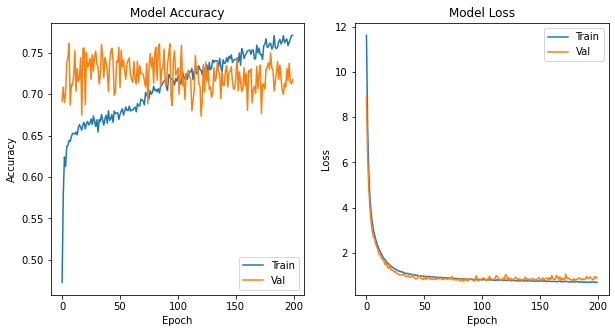

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_REG.history['accuracy'])
plt.plot(history_REG.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_REG.history['loss'])
plt.plot(history_REG.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

**Observation:** 
- Looks like the regularization worked, model loss seem to be a lot more stable.

In [70]:
model_best_REG.evaluate(test_x, test_y)

60/60 [==============================] - 0s 3ms/step - loss: 0.9439 - accuracy: 0.7314


[0.9438679218292236, 0.7313510775566101]

Our overall model accuracy has also increased compared to the previous models.

## Building a Convolutional Neural Network Model

Our base NN model may not be the best at predicting unseen data as it has poor performance on the validation set. Hence we will be using a Deep Neural Network called **Convolution Neural Network (CNN)**. Which is a widely used network for image classification.

### Data Loader

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),   # Image Size
        batch_size=batch_size,
        class_mode='categorical',
        suffle=True,
        seed=123)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),   # Image Size
        batch_size=batch_size,
        class_mode='categorical',
        suffle=True,
        seed=123)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),   # Image Size
        batch_size=batch_size,
        class_mode='categorical',
        suffle=True,
        seed=123)

Found 6057 validated image filenames belonging to 4 classes.
Found 1922 validated image filenames belonging to 4 classes.
Found 1917 validated image filenames belonging to 4 classes.


### Base CNN Structure

As a starting point we will be using the **LeNet** architecture. Since our base model shows signs of overfitting we will be using **Regularization** and **Dropout** to address this issue.

In [73]:
reg_lambda = 0.001

model_CNN = keras.Sequential([ 
    keras.layers.Input(shape=(27, 27, 3)),
    keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    keras.layers.Activation('relu'),
    
    keras.layers.Conv2D(64, (3, 3)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])


In [74]:
model_CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 25, 25, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)         

### Compile CNN Model

Base compiler for **LeNet** model.

In [75]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_CNN.compile(optimizer=sgd,
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics='categorical_accuracy')

### Training CNN Model

In [76]:
history_CNN = model_CNN.fit_generator(train_generator, 
                                      validation_data = val_generator, 
                                      epochs=150, verbose=0,
                                      steps_per_epoch=train_data.shape[0]//batch_size,  # Makes training efficient since we are creating aumented images
                                      validation_steps=val_data.shape[0]//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.


### Visualise Model Accuracy and Loss

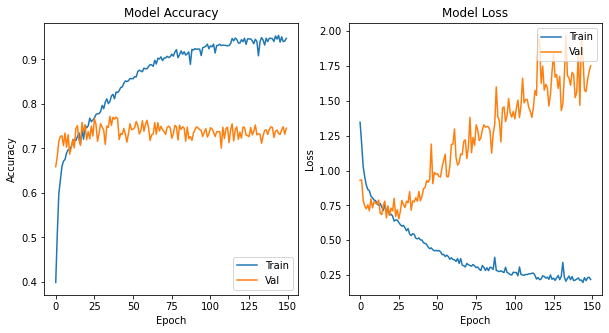

In [77]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_CNN.history['categorical_accuracy'])
plt.plot(history_CNN.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

**Observation:**
- The model achieved a higher accuracy compared to a normal Neural Network.
- The overfitting issue seems to be worse, could be due to the increase in complexity of the model and the lack of training data.

In [81]:
model_CNN.evaluate(test_generator)

60/60 [==============================] - 1s 12ms/step - loss: 1.9851 - categorical_accuracy: 0.6432


[1.9850809574127197, 0.6431924700737]

We can now save this model for future use.

In [82]:
model_CNN.save('model_CNN')

INFO:tensorflow:Assets written to: model_CNN/assets


### Data Augmentation

Since our dataset is very small and is not ideal for CNN and also since we have some class inbalance, we can use **Data Augmentation** to deal with these issues. This can also minimise overfitting.

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_AUG = ImageDataGenerator(rescale=1./255,                    # Normalize images       
                                   data_format='channels_last',
                                   rotation_range=45,                 # Orientation of the same cell type can vary  
                                   zoom_range = (0.9, 0.9),
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,              
                                   horizontal_flip = True,      
                                   vertical_flip = True,)


train_generator_AUG = train_datagen_AUG.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),   # Image Size
        batch_size=batch_size,
        class_mode='categorical',
        suffle=True,
        seed=123)

Found 6057 validated image filenames belonging to 4 classes.


**Transformations:**
- By plotting the images we noticed that the orientation of the same cell type can vary, hence will use transformations such as `rotation_range`, `zoom_range`, `width_shift_range`, `height_shift_range`, `horizontal_flip` and `vertical_flip`.

We will still be using the same CNN model structure since we want to evaluate how our augmented data performs on our model.

In [84]:
model_CNN_AUG = keras.Sequential([ 
    keras.layers.Input(shape=(27, 27, 3)),
    keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    keras.layers.Activation('relu'),
    
    keras.layers.Conv2D(64, (3, 3)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

Since our dataset has class inbalance using `accuracy` as our performance metrics may not be the best since it is unable to correctly distinguish between the numbers of correctly classified examples of different classes. For this we can use `precision` which will give us a percentage of how many cells that were predicted as a certain class actually matches the label. We will also use `recall` which will give us the proportion of correctly classified classes. Lastly we will use `auc` also known as **Area Under The Curve** to get the performance of our model using `precision` and `recall`.

In [26]:
METRICS = [keras.metrics.CategoricalAccuracy(name="categorical_accuracy"),
           keras.metrics.Precision(name="precision"),
           keras.metrics.Recall(name="recall"),
           keras.metrics.AUC(name="auc")]

In [86]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_CNN_AUG.compile(optimizer=sgd,
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

### Training CNN Model with Augmented Data

In [87]:
history_CNN_AUG = model_CNN_AUG.fit_generator(train_generator_AUG, 
                                      validation_data = val_generator, 
                                      epochs=150, verbose=0,
                                      steps_per_epoch=train_data.shape[0]//batch_size,
                                      validation_steps=val_data.shape[0]//batch_size)

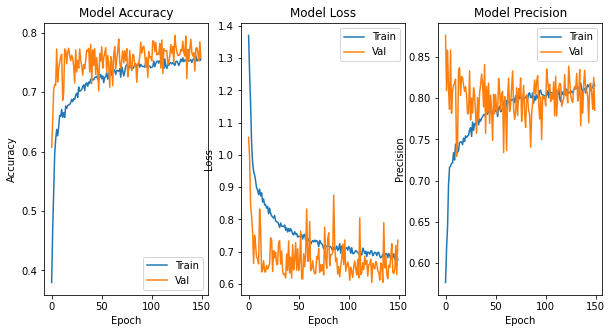

In [88]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(history_CNN_AUG.history['categorical_accuracy'])
plt.plot(history_CNN_AUG.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')

plt.subplot(1,3,2)
plt.plot(history_CNN_AUG.history['loss'])
plt.plot(history_CNN_AUG.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.subplot(1,3,3)
plt.plot(history_CNN_AUG.history['precision'])
plt.plot(history_CNN_AUG.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

In [89]:
model_CNN_AUG.evaluate(test_generator)

60/60 [==============================] - 1s 12ms/step - loss: 0.7966 - categorical_accuracy: 0.7230 - precision: 0.7672 - recall: 0.6635 - auc: 0.9103


[0.7965776920318604,
 0.7230046987533569,
 0.7671893835067749,
 0.663536787033081,
 0.9102512001991272]

**Observation:**
- Model seem to be less overfitting meaning data augmentation was helpful.

### Hyperparemeter Tuning

Updating the lambda value to `0.01`.

In [24]:
reg_lambda = 0.01
model_CNN_AUG_v2 = keras.Sequential([ 
    keras.layers.Input(shape=(27, 27, 3)),
    keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    keras.layers.Activation('relu'),
    
    keras.layers.Conv2D(64, (3, 3)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])


Using the `adam` optimiser instead of `sgd`.

In [27]:
model_CNN_AUG_v2.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

Training up to `200 epochs`.

In [32]:
history_CNN_AUG_v2 = model_CNN_AUG_v2.fit_generator(train_generator_AUG, 
                                      validation_data = val_generator, 
                                      epochs=200, verbose=0)

Instructions for updating:
Please use Model.fit, which supports generators.


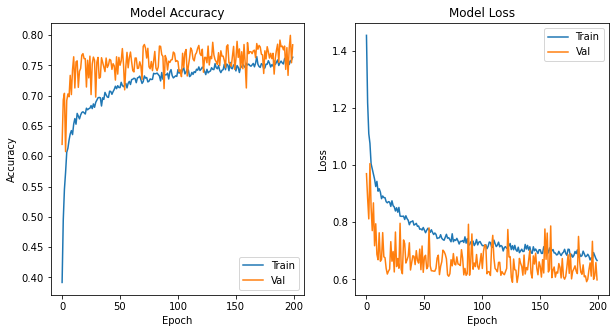

In [33]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_CNN_AUG_v2.history['categorical_accuracy'])
plt.plot(history_CNN_AUG_v2.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')


# plt.subplot(1,2,2)
# plt.plot(history_CNN_AUG_v2.history['precision'])
# plt.plot(history_CNN_AUG_v2.history['val_precision'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_CNN_AUG_v2.history['loss'])
plt.plot(history_CNN_AUG_v2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')



plt.show()

In [ ]:
model_CNN_AUG_v2.evaluate(test_generator)